#**„Alzheimer Prediction with NACC MRI Data“**

## Вовед

Алцхајмеровата болест (АБ) е најчесто јавувачко невродегенеративно нарушување кое постепено ја нарушува меморијата, когнитивните функции и секојдневното функционирање на лицето. Со оглед на прогресивниот карактер на болеста, раната идентификација и предвидување на развојот на симптомите се од клучно значење за навремена интервенција и подобрување на квалитетот на животот на пациентите.

Со напредокот на медицинските технологии и машинското учење, можноста за предвидување на развојот на Алцхајмер стана реална преку анализа на <strong>MRI слики</strong> и клинички податоци. MRI (Magnetic Resonance Imaging) овозможува детален увид во морфологијата на мозокот и открива структурни промени кои се поврзани со напредокот на болеста.
</p>

Во овој проект се користат податоци од <strong>National Alzheimer’s Coordinating Center (NACC)</strong>, кои вклучуваат три главни типови на информации:

<ul>
<li><strong>MRI QC податоци (`mriqc_df`)</strong> – информации за квалитетот на MRI скеновите, како сигнал-шум однос, artifacts и motion, критични за сигурна анализа.</li>
<li><strong>MRI SBM податоци (`mrisbm_df`)</strong> – морфометриски мерења на мозочни региони, вклучувајќи обем, дебелина на кората и волумен на различни структури, кои овозможуваат анализа на структурни промени поврзани со прогресија на Алцхајмер.</li>
<li><strong>Пациентски податоци (`patients_df`)</strong> – демографски и клинички информации, како возраст, пол, дијагноза, терапија и други релевантни показатели, кои се користат за подобрување на точноста на моделот.</li>
</ul>

Целта на проектот е да се развие модел за <strong>предвидување на развој на Алцхајмерова болест</strong> користејќи комбинација од MRI и клинички податоци. За таа цел, се користи <strong>LSTM (Long Short-Term Memory) модел</strong>, кој е тип на рекурентна невронска мрежа и овозможува моделирање на <strong>времески серии и хронолошки зависности</strong> во податоците за секој пациент.



Овој пристап овозможува комбинација на структурни MRI податоци со клинички информации за развој на <strong>прецизен и персонализиран модел за предвидување</strong>, кој може да помогне во рана дијагноза и подобрување на терапевтските стратегии.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
import shap

## Почетни табели и нивно процесирање

In [4]:
mriqc_df = pd.read_csv("/content/drive/MyDrive/vnp/proekt/investigator_scan_mriqc_nacc69.csv")
mrisbm_df = pd.read_csv("/content/drive/MyDrive/vnp/proekt/investigator_scan_mrisbm_nacc69.csv")
patients_df = pd.read_csv("/content/drive/MyDrive/vnp/proekt/investigator_nacc69.csv")

/tmp/ipython-input-2492028897.py:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  mriqc_df = pd.read_csv("/content/drive/MyDrive/vnp/proekt/investigator_scan_mriqc_nacc69.csv")
/tmp/ipython-input-2492028897.py:3: DtypeWarning: Columns (20,22,24,26,28,41,44,46,48,51,61,63,65,67,69,71,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,134,156,165,176,179,189,217,220,222,224,226,228,230,232,234,236,238,240,242,244,246,248,250,252,254,256,258,260,262,264,266,268,270,272,382,397,399,401,419,421,423,432,445,454,494,574,605,613,638,674,690,704,707,710,715,727,738,744,746,804,809,810,811,812,820,831,833,835,837,843,904,959,960,961,969,970,971,972,982,1004,1007,1010) have mixed types. Specify dtype option on import or set low_memory=False.
  patients_df = pd.read_csv("/content/drive/MyDrive/vnp/proekt/investigator_nacc69.csv")


Табела 1 - Оценка на квалитетот на MRI снимките

In [5]:
mriqc_df

,NACCID,NACCADC,STUDYDATE,SERIESTIME,STUDYVISITCODE,SERIESNUMBER,SERIESTYPE,STUDYQC,STUDYQCCOMMENT,MRIPROTOCOLPHASE,...,NUMBERVOLUMES,SLICESPERVOLUME,SLICETHICKNESS,RECEIVECOILNAME,STUDYINSTANCEUID,SERIESINSTANCEUID,DEFACESTATUS,LONISTUDY,LONISERIES,LONIIMAGE
0,NACC914051,6518,2022-04-04,08:19:13,NaN,4,FLAIR,1,NaN,SCAN1,...,1,160,1.200000,NOT SET,2.16.124.113543.6006.99.8664815185309774589,2.16.124.113543.6006.99.2228542173715200898,1,212155,5092097,10146748
1,NACC914051,6518,2022-04-04,08:14:44,NaN,3,T1w,1,NaN,SCAN1,...,1,176,1.000000,NOT SET,2.16.124.113543.6006.99.8664815185309774589,2.16.124.113543.6006.99.04770984303719806076,1,212155,5092098,10146749
2,NACC914653,1553,2023-03-30,14:48:11,NaN,301,FLAIR,1,NaN,SCAN1,...,1,160,1.200000,MULTI COIL,2.16.124.113543.6006.99.8709443170425982409,2.16.124.113543.6006.99.1706733019930062217,1,233263,5138722,10212042
3,NACC914653,1553,2023-03-30,14:41:32,NaN,201,T1w,1,NaN,SCAN1,...,1,211,1.000000,MULTI COIL,2.16.124.113543.6006.99.8709443170425982409,2.16.124.113543.6006.99.4764486320387263152,1,233263,5138721,10212041
4,NACC913685,4032,2022-06-08,12:37:51,NaN,9,T1w,1,NaN,SCAN1,...,1,196,1.000000,RM:8HRBrain,2.16.124.113543.6006.99.1372730843030960706,2.16.124.113543.6006.99.4708347644596574889,1,216978,5100658,10162707
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17067,NACC603586,289,2024-08-29,12:00:24,NaN,2,T1w,1,NaN,SCAN1,...,1,208,1.000000,NOT SET,2.16.124.113543.6006.99.6394014613926763671,2.16.124.113543.6006.99.06753093099102481778,1,343542,5868695,11109543
17068,NACC603586,289,2024-08-29,12:15:44,NaN,12,FLAIR,1,NaN,SCAN1,...,1,160,1.200000,NOT SET,2.16.124.113543.6006.99.6394014613926763671,2.16.124.113543.6006.99.2961947425576789075,1,343542,5868694,11109542
17069,NACC849011,8646,2024-08-29,09:21:30,NaN,22,BOLD,1,NaN,SCAN1,...,100,48,3.299999,NOT SET,2.16.124.113543.6006.99.0151481936420034333,2.16.124.113543.6006.99.2769546409040718564,2,343508,5868447,11109229
17070,NACC849011,8646,2024-08-29,09:09:47,NaN,13,T1w,1,NaN,SCAN1,...,1,208,1.000000,NOT SET,2.16.124.113543.6006.99.0151481936420034333,2.16.124.113543.6006.99.1492439079189585364,1,343508,5868448,11109230


Табела 2 - Анализа на морфометрија на мозокот базирана на MRI слики.

In [6]:
mrisbm_df

,NACCID,NACCADC,SCANDT,DESCRIPTION_T1,LONI_IMAGE_T1,DESCRIPTION_FLAIR,LONI_IMAGE_FLAIR,CEREBRUMTCV,GM,WMH,...,LH_TRANSVERSETEMPORAL_SAREA,RH_TRANSVERSETEMPORAL_SAREA,LH_TRANSVERSETEMPORAL_AVGTH,RH_TRANSVERSETEMPORAL_AVGTH,LH_INSULA_GVOL,RH_INSULA_GVOL,LH_INSULA_SAREA,RH_INSULA_SAREA,LH_INSULA_AVGTH,RH_INSULA_AVGTH
0,NACC010462,4032,2021-04-27,3DT1,10350249,FLAIR,10350250,1315.75,618.842,1.56800,...,448,295,2.459,2.228,5919,6382,2265,2667,2.482,2.295
1,NACC013705,4032,2021-06-29,3DT1,10335319,FLAIR,10335320,1214.62,592.752,0.51700,...,481,365,2.546,2.273,6465,6258,1905,1826,3.134,3.094
2,NACC017553,2289,2022-04-27,3DT1,10660798,FLAIR,10397819,1269.84,602.520,4.04800,...,369,275,2.417,2.211,5291,5590,1864,1905,2.721,2.876
3,NACC017553,2289,2022-05-18,3DT1,10660796,FLAIR,10397816,1242.88,594.181,5.59100,...,336,251,2.465,2.193,5054,5437,1739,1867,2.840,2.879
4,NACC017553,2289,2023-08-14,3DT1,10394092,FLAIR,10376517,1292.89,604.372,9.30200,...,364,262,2.408,2.249,5147,5437,1786,1860,2.754,2.839
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4945,NACC998966,911,2024-05-15,3DT1,10987722,FLAIR,10987723,1301.77,638.193,38.85050,...,496,327,1.721,1.610,5979,5430,1989,1895,2.866,2.812
4946,NACC999180,238,2021-11-03,3DT1,10951823,FLAIR,10951824,1038.20,553.195,2.33900,...,378,280,2.338,2.354,5456,5553,1902,1868,2.785,2.883
4947,NACC999180,238,2024-04-05,3DT1,11044260,FLAIR,11044261,1036.95,568.521,1.58600,...,347,259,2.373,2.431,5294,5408,1717,1892,2.923,2.816
4948,NACC999225,2578,2024-04-16,3DT1,10973646,FLAIR,10973647,1044.92,545.362,1.34400,...,422,273,2.352,2.428,5939,5868,1723,1645,3.213,3.216


Табела 3 - Клинички и демографски информации за пациентите

In [7]:
patients_df

,NACCID,NACCADC,PACKET,FORMVER,VISITMO,VISITDAY,VISITYR,NACCVNUM,NACCAVST,NACCNVST,...,NPATGAM1,NPATGAM2,NPATGAM3,NPATGAM4,NPATGAM5,NPATGFRN,NPATGFR1,NPATGFR2,NPATGFR3,NPATGFR4
0,NACC002909,186,I,3.0,12,28,2022,1,2,2,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4
1,NACC002909,186,F,3.0,1,23,2024,2,2,2,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4
2,NACC003487,186,I,3.0,11,15,2023,1,1,1,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4
3,NACC004352,186,I,3.0,10,5,2021,1,1,1,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4
4,NACC004687,186,I,3.0,11,14,2022,1,2,2,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201347,NACC998475,9661,F,2.0,11,6,2008,3,3,3,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4
201348,NACC999391,9661,I,1.0,3,2,2006,1,3,3,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4
201349,NACC999391,9661,F,1.0,5,17,2007,2,3,3,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4
201350,NACC999391,9661,F,2.0,3,27,2008,3,3,3,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4


Претстава на таргет променлива

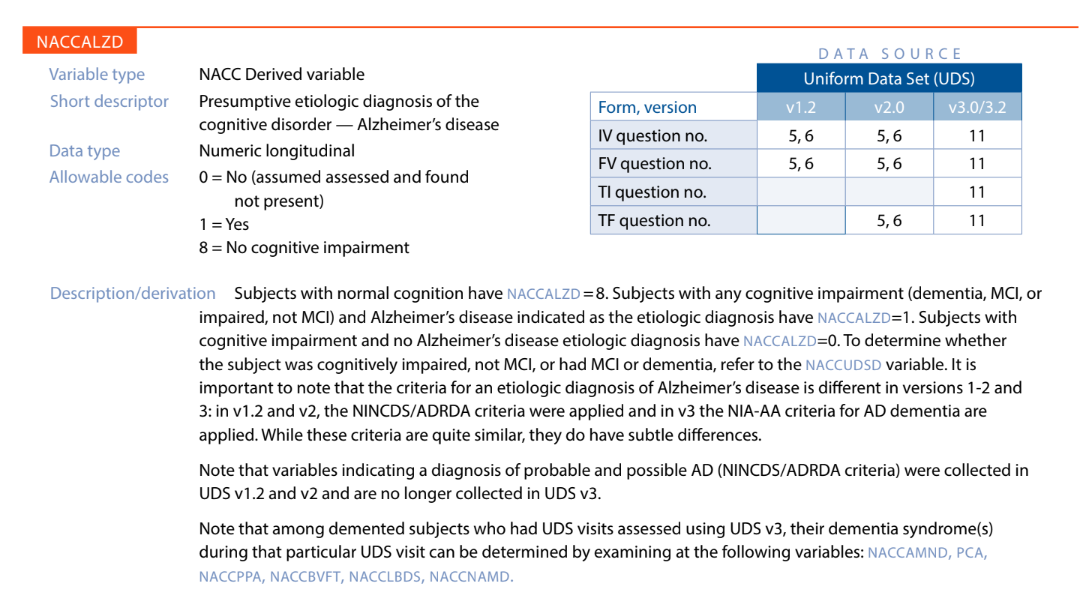

In [8]:
patients_df['NACCALZD'].value_counts()

,count
NACCALZD,
8,98451
1,69326
0,33575


Се прикажуваат уникатните вредности за секоја колона во MRIQC табелата, за да се разбере видот и опсегот на податоците. Овие информации се документираат и објаснуваат во Word документ, зачуван на Google Drive, со цел подобро разбирање на податоците и нивната интерпретација.

In [9]:
for col in mriqc_df.columns:
    print(f"Колона: {col}")
    print(mriqc_df[col].unique())
    print("-" * 40)

Колона: NACCID
['NACC914051' 'NACC914653' 'NACC913685' ... 'NACC486952' 'NACC603586'
 'NACC849011']
----------------------------------------
Колона: NACCADC
[6518 1553 4032 2289 2125  943 8361 5452 6499 5783 2096 1018  289 8658
 4347 9661 8646 4935 2578  490 6061 3630  354 2793  911 8073 1354  238
 2958 8974 8683 8354  740  186]
----------------------------------------
Колона: STUDYDATE
['2022-04-04' '2023-03-30' '2022-06-08' ... '2025-01-14' '2025-01-03'
 '2025-01-16']
----------------------------------------
Колона: SERIESTIME
['08:19:13' '08:14:44' '14:48:11' ... '09:21:30' '09:09:47' '09:19:31']
----------------------------------------
Колона: STUDYVISITCODE
[nan]
----------------------------------------
Колона: SERIESNUMBER
[    4     3   301   201     9    10     8     5     6     2    16     7
    15    11    63    17    18  1301  1001    13    20    39    19    31
    14    25    22    12  8001  6001  4001    27    24    28    32    26
    23   901   701    33   801 23001  9001

In [10]:
for col in mrisbm_df.columns:
    unique_vals = mrisbm_df[col].unique()
    print(f"Колона: {col}")
    print(unique_vals[:10])
    if len(unique_vals) > 10:
        print(f"...и уште {len(unique_vals) - 10} други уникатни вредности")
    print("-" * 40)


Колона: NACCID
['NACC010462' 'NACC013705' 'NACC017553' 'NACC804289' 'NACC813058'
 'NACC777529' 'NACC623388' 'NACC676469' 'NACC151305' 'NACC154455']
...и уште 4109 други уникатни вредности
----------------------------------------
Колона: NACCADC
[4032 2289 2958 6499 1553 3630 8658 2096 2125 1354]
...и уште 22 други уникатни вредности
----------------------------------------
Колона: SCANDT
['2021-04-27' '2021-06-29' '2022-04-27' '2022-05-18' '2023-08-14'
 '2024-08-13' '2021-06-03' '2023-09-28' '2021-06-15' '2021-06-11']
...и уште 957 други уникатни вредности
----------------------------------------
Колона: DESCRIPTION_T1
['3DT1']
----------------------------------------
Колона: LONI_IMAGE_T1
[10350249 10335319 10660798 10660796 10394092 10929708 10363676 10316306
 10363674 10363670]
...и уште 4940 други уникатни вредности
----------------------------------------
Колона: DESCRIPTION_FLAIR
['FLAIR']
----------------------------------------
Колона: LONI_IMAGE_FLAIR
[10350250 10335320 103978

In [11]:
for col in patients_df.columns:
    unique_vals = patients_df[col].unique()
    print(f"Колона: {col}")
    print(unique_vals[:10])
    if len(unique_vals) > 10:
        print(f"...и уште {len(unique_vals) - 10} други уникатни вредности")
    print("-" * 40)


Колона: NACCID
['NACC002909' 'NACC003487' 'NACC004352' 'NACC004687' 'NACC007213'
 'NACC008514' 'NACC009426' 'NACC013204' 'NACC013667' 'NACC014621']
...и уште 54015 други уникатни вредности
----------------------------------------
Колона: NACCADC
[ 186  238  289  354  490  740  911  943 1018 1354]
...и уште 36 други уникатни вредности
----------------------------------------
Колона: PACKET
['I' 'F' 'T' 'IT']
----------------------------------------
Колона: FORMVER
[3.  3.2 2.  1. ]
----------------------------------------
Колона: VISITMO
[12  1 11 10  9  5  4  8  3  2]
...и уште 2 други уникатни вредности
----------------------------------------
Колона: VISITDAY
[28 23 15  5 14  4 24 20 25  7]
...и уште 21 други уникатни вредности
----------------------------------------
Колона: VISITYR
[2022 2024 2023 2021 2019 2020 2025 2009 2010 2011]
...и уште 11 други уникатни вредности
----------------------------------------
Колона: NACCVNUM
[ 1  2  3  4  5  6  7  8  9 10]
...и уште 10 други уник

**Филтрирање на 1табела**

*STUDYQC (Оценка за квалитет на студијата)*

Вредности: 1 (pass), 4 (fail), -1 (not assessed)

Се зема само 1.

<br>

*STUDYRESCANREQUESTED (Дали е побарано ново снимање)*

Вредности: 0 (не е побарано повторно снимање), 1 (побарано повторно снимање)

Се зема само 0.

<br>

*STUDYPROTOCOL (Статус на протоколот)*

Вредности: 1 (pass), 4 (fail), -1 (not assessed)

Се зема само 1.

<br>

*RELEASEFORANALYSIS (Дали е дозволено користење за анализа )*

Вредности: 1 (correct protocol and pass quality), 2 (correct protocol but failed quality), 3 (incorrect protocol)

Се зема само 1.

<br>

*SERIESCHOSEN (Дали серијата е избрана за анализа )*

Вредности: 1 (use), 0 (do not use)

Се зема само 1.

In [12]:
filtered_mriqc_df = mriqc_df[(mriqc_df['STUDYQC'] == 1) & (mriqc_df['STUDYRESCANREQUESTED'] == 0) & (mriqc_df['STUDYPROTOCOL'] == 1) & (mriqc_df['RELEASEFORANALYSIS']==1) & (mriqc_df['SERIESCHOSEN'] == 1)]

In [13]:
filtered_mriqc_df

,NACCID,NACCADC,STUDYDATE,SERIESTIME,STUDYVISITCODE,SERIESNUMBER,SERIESTYPE,STUDYQC,STUDYQCCOMMENT,MRIPROTOCOLPHASE,...,NUMBERVOLUMES,SLICESPERVOLUME,SLICETHICKNESS,RECEIVECOILNAME,STUDYINSTANCEUID,SERIESINSTANCEUID,DEFACESTATUS,LONISTUDY,LONISERIES,LONIIMAGE
0,NACC914051,6518,2022-04-04,08:19:13,NaN,4,FLAIR,1,NaN,SCAN1,...,1,160,1.2,NOT SET,2.16.124.113543.6006.99.8664815185309774589,2.16.124.113543.6006.99.2228542173715200898,1,212155,5092097,10146748
1,NACC914051,6518,2022-04-04,08:14:44,NaN,3,T1w,1,NaN,SCAN1,...,1,176,1.0,NOT SET,2.16.124.113543.6006.99.8664815185309774589,2.16.124.113543.6006.99.04770984303719806076,1,212155,5092098,10146749
2,NACC914653,1553,2023-03-30,14:48:11,NaN,301,FLAIR,1,NaN,SCAN1,...,1,160,1.2,MULTI COIL,2.16.124.113543.6006.99.8709443170425982409,2.16.124.113543.6006.99.1706733019930062217,1,233263,5138722,10212042
3,NACC914653,1553,2023-03-30,14:41:32,NaN,201,T1w,1,NaN,SCAN1,...,1,211,1.0,MULTI COIL,2.16.124.113543.6006.99.8709443170425982409,2.16.124.113543.6006.99.4764486320387263152,1,233263,5138721,10212041
4,NACC913685,4032,2022-06-08,12:37:51,NaN,9,T1w,1,NaN,SCAN1,...,1,196,1.0,RM:8HRBrain,2.16.124.113543.6006.99.1372730843030960706,2.16.124.113543.6006.99.4708347644596574889,1,216978,5100658,10162707
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17058,NACC087772,8646,2024-06-27,09:23:20,NaN,14,T1w,1,NaN,SCAN1,...,1,208,1.0,NOT SET,2.16.124.113543.6006.99.02302294226446244397,2.16.124.113543.6006.99.4464185574098489593,1,343014,5864727,11103621
17059,NACC087772,8646,2024-06-27,09:32:22,NaN,21,FLAIR,1,NaN,SCAN1,...,1,208,1.0,NOT SET,2.16.124.113543.6006.99.02302294226446244397,2.16.124.113543.6006.99.03139116205974999055,1,343014,5864721,11103613
17060,NACC087772,8646,2024-06-27,10:00:46,NaN,40,T2starw,1,NaN,SCAN1,...,1,44,4.0,NOT SET,2.16.124.113543.6006.99.02302294226446244397,2.16.124.113543.6006.99.05039204213529275963,1,343014,5864703,11103595
17067,NACC603586,289,2024-08-29,12:00:24,NaN,2,T1w,1,NaN,SCAN1,...,1,208,1.0,NOT SET,2.16.124.113543.6006.99.6394014613926763671,2.16.124.113543.6006.99.06753093099102481778,1,343542,5868695,11109543


Табелата со податоци е подредена по пациент (NACCID), центарот (NACCADC) и датум/време на студија (STUDYDATE и SERIESTIME), со конверзија на датумот во стандарден формат.

In [14]:
filtered_mriqc_df['STUDYDATE'] = pd.to_datetime(filtered_mriqc_df['STUDYDATE'])
filtered_mriqc_df = filtered_mriqc_df.sort_values(by=['NACCID', 'NACCADC', 'STUDYDATE', 'SERIESTIME'])

/tmp/ipython-input-361988466.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_mriqc_df['STUDYDATE'] = pd.to_datetime(filtered_mriqc_df['STUDYDATE'])


In [15]:
filtered_mriqc_df

,NACCID,NACCADC,STUDYDATE,SERIESTIME,STUDYVISITCODE,SERIESNUMBER,SERIESTYPE,STUDYQC,STUDYQCCOMMENT,MRIPROTOCOLPHASE,...,NUMBERVOLUMES,SLICESPERVOLUME,SLICETHICKNESS,RECEIVECOILNAME,STUDYINSTANCEUID,SERIESINSTANCEUID,DEFACESTATUS,LONISTUDY,LONISERIES,LONIIMAGE
12955,NACC000138,9661,2023-07-13,12:05:44,NaN,201,T1w,1,NaN,SCAN1,...,1,211,1.000000,MULTI COIL,2.16.124.113543.6006.99.8780000302022618504,2.16.124.113543.6006.99.2822006648554026211,1,270496,5288303,10446001
12956,NACC000138,9661,2023-07-13,12:12:19,NaN,301,FLAIR,1,NaN,SCAN1,...,1,160,1.200000,MULTI COIL,2.16.124.113543.6006.99.8780000302022618504,2.16.124.113543.6006.99.04855533009405899130,1,270496,5288304,10446002
9652,NACC000176,2125,2023-01-31,11:12:51,NaN,2,T1w,1,NaN,SCAN1,...,1,176,1.199999,NOT SET,2.16.124.113543.6006.99.1358191608321316907,2.16.124.113543.6006.99.07490623421193577127,1,240666,5158447,10240079
9651,NACC000176,2125,2023-01-31,11:18:40,NaN,3,FLAIR,1,NaN,SCAN1,...,1,160,1.200000,NOT SET,2.16.124.113543.6006.99.1358191608321316907,2.16.124.113543.6006.99.4750640184789503755,1,240666,5158446,10240078
9650,NACC000176,2125,2023-01-31,11:20:48,NaN,4,T2starw,1,NaN,SCAN1,...,1,44,4.000000,NOT SET,2.16.124.113543.6006.99.1358191608321316907,2.16.124.113543.6006.99.7246553115759883495,1,240666,5158445,10240077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15382,NACC999617,911,2023-04-11,13:22:18,NaN,3,T1w,1,NaN,SCAN1,...,1,176,1.199999,NOT SET,2.16.124.113543.6006.99.08649542977013080381,2.16.124.113543.6006.99.04472342604539202986,1,322201,5758925,10966420
15383,NACC999617,911,2023-04-11,13:27:18,NaN,4,FLAIR,1,NaN,SCAN1,...,1,160,1.200000,NOT SET,2.16.124.113543.6006.99.08649542977013080381,2.16.124.113543.6006.99.04556994076320119809,1,322201,5758926,10966421
15381,NACC999617,911,2023-04-11,14:03:50,NaN,17,T2w_HighResHippo,1,NaN,SCAN1,...,1,448,2.000000,NOT SET,2.16.124.113543.6006.99.08649542977013080381,2.16.124.113543.6006.99.1789156065844633435,2,322201,5758924,10966419
10625,NACC999821,6518,2022-11-30,09:44:48,NaN,3,T1w,1,NaN,SCAN1,...,1,176,1.000000,NOT SET,2.16.124.113543.6006.99.05630225732083075577,2.16.124.113543.6006.99.2968930294390510565,1,219536,5105036,10169389


**Филтрирање на 2табела**

Од MRISBM табелата се отстрануваат непотребните колони кои немаат клиничка значајност, со цел да се намали сложеноста на податоците.


In [16]:
filtered_mrisbm_df = mrisbm_df.drop(columns=['DESCRIPTION_T1', 'DESCRIPTION_FLAIR', 'FREESURFER_VERSION', 'RECEIVECOILNAME', 'SOFTWAREVERSION', 'SCANNERMODEL', 'SCANNERMANUFACTURER', 'LONI_IMAGE_T1', 'LONI_IMAGE_FLAIR', 'LONISTUDY',	'LONISERIES',	'LONIIMAGE' 'ACCELERATION', 'ACQUISITIONPLANE', 'ACQUISITIONTYPE', 'NUMBERVOLUMES', 'SLICESPERVOLUME', 'SLICETHICKNESS', 'DEFACESTATUS'], errors='ignore')

In [17]:
filtered_mrisbm_df

,NACCID,NACCADC,SCANDT,CEREBRUMTCV,GM,WMH,LEFT_HIPPO,RIGHT_HIPPO,HIPPOCAMPUS,LH_CAUDALANTERIORCINGULATE_GVOL,...,LH_TRANSVERSETEMPORAL_SAREA,RH_TRANSVERSETEMPORAL_SAREA,LH_TRANSVERSETEMPORAL_AVGTH,RH_TRANSVERSETEMPORAL_AVGTH,LH_INSULA_GVOL,RH_INSULA_GVOL,LH_INSULA_SAREA,RH_INSULA_SAREA,LH_INSULA_AVGTH,RH_INSULA_AVGTH
0,NACC010462,4032,2021-04-27,1315.75,618.842,1.56800,2.80000,2.86200,5.66200,2657,...,448,295,2.459,2.228,5919,6382,2265,2667,2.482,2.295
1,NACC013705,4032,2021-06-29,1214.62,592.752,0.51700,2.48800,2.03700,4.52500,2989,...,481,365,2.546,2.273,6465,6258,1905,1826,3.134,3.094
2,NACC017553,2289,2022-04-27,1269.84,602.520,4.04800,3.39100,2.87400,6.26500,2761,...,369,275,2.417,2.211,5291,5590,1864,1905,2.721,2.876
3,NACC017553,2289,2022-05-18,1242.88,594.181,5.59100,3.20100,3.07000,6.27100,3433,...,336,251,2.465,2.193,5054,5437,1739,1867,2.840,2.879
4,NACC017553,2289,2023-08-14,1292.89,604.372,9.30200,3.31200,3.16100,6.47300,2640,...,364,262,2.408,2.249,5147,5437,1786,1860,2.754,2.839
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4945,NACC998966,911,2024-05-15,1301.77,638.193,38.85050,3.23832,3.46391,6.70223,2069,...,496,327,1.721,1.610,5979,5430,1989,1895,2.866,2.812
4946,NACC999180,238,2021-11-03,1038.20,553.195,2.33900,2.88200,2.76800,5.65000,2210,...,378,280,2.338,2.354,5456,5553,1902,1868,2.785,2.883
4947,NACC999180,238,2024-04-05,1036.95,568.521,1.58600,2.82100,2.73900,5.56000,2360,...,347,259,2.373,2.431,5294,5408,1717,1892,2.923,2.816
4948,NACC999225,2578,2024-04-16,1044.92,545.362,1.34400,2.95200,3.01300,5.96500,2540,...,422,273,2.352,2.428,5939,5868,1723,1645,3.213,3.216


Табелата со податоци е подредена по пациент (NACCID), и датум (SCANDT), со конверзија на датумот во стандарден формат.

In [18]:
filtered_mrisbm_df['SCANDT'] = pd.to_datetime(filtered_mrisbm_df ['SCANDT'], errors='coerce')
filtered_mrisbm_df = filtered_mrisbm_df.sort_values(by=['NACCID', 'SCANDT'])

In [19]:
filtered_mrisbm_df

,NACCID,NACCADC,SCANDT,CEREBRUMTCV,GM,WMH,LEFT_HIPPO,RIGHT_HIPPO,HIPPOCAMPUS,LH_CAUDALANTERIORCINGULATE_GVOL,...,LH_TRANSVERSETEMPORAL_SAREA,RH_TRANSVERSETEMPORAL_SAREA,LH_TRANSVERSETEMPORAL_AVGTH,RH_TRANSVERSETEMPORAL_AVGTH,LH_INSULA_GVOL,RH_INSULA_GVOL,LH_INSULA_SAREA,RH_INSULA_SAREA,LH_INSULA_AVGTH,RH_INSULA_AVGTH
1048,NACC000138,9661,2023-07-13,1098.37,564.659,0.390000,3.59400,3.58200,7.17600,1987,...,405,330,2.515,2.291,5555,5284,1729,1702,3.206,3.142
2148,NACC000176,2125,2023-01-31,1088.37,614.530,0.459185,2.91529,2.93531,5.85060,2819,...,411,295,2.411,2.621,6394,5919,1786,1803,3.234,3.025
3333,NACC000292,911,2022-11-03,1205.06,626.178,1.356000,3.43500,3.38400,6.81900,2602,...,498,354,2.164,2.156,5343,5614,1940,2086,2.757,2.722
1960,NACC000314,4935,2024-02-20,1361.43,669.146,2.474000,2.96300,2.61400,5.57700,2999,...,424,282,2.017,1.969,6243,6254,2201,2309,2.697,2.593
1961,NACC000806,6061,2023-01-25,1271.12,646.616,0.123000,3.23700,3.24400,6.48100,2787,...,555,374,2.156,2.355,5652,6048,2042,2077,2.765,2.941
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4294,NACC999546,3630,2022-11-23,1261.09,630.593,1.026000,3.26000,3.13500,6.39500,3394,...,484,391,2.063,2.314,6090,6479,1847,1917,3.115,3.089
1083,NACC999573,5783,2022-09-09,1135.26,582.564,7.696000,3.01000,3.05100,6.06100,2045,...,456,353,2.432,2.378,5217,5569,1777,1854,2.743,2.756
4949,NACC999617,911,2023-04-11,1074.84,557.148,1.711260,3.32775,3.45857,6.78632,2174,...,315,231,2.344,2.423,4921,5227,1684,1882,2.900,2.849
4295,NACC999633,2289,2024-02-08,1250.20,642.485,2.187000,3.51700,3.59100,7.10800,2934,...,409,318,2.707,2.658,5825,5920,1969,2013,2.859,2.870


Во MRISBM таблицата колоната SCANDT е преименувана во STUDYDATE за усогласување, по што двете таблици (MRIQC и MRISBM) се спојуваат по пациент (NACCID), центар (NACCADC) и датум на студија (STUDYDATE) користејќи внатрешно спојување.

In [20]:
filtered_mrisbm_df = filtered_mrisbm_df.rename(columns={'SCANDT': 'STUDYDATE'})

merged_df = pd.merge(
    filtered_mriqc_df,
    filtered_mrisbm_df,
    on=['NACCID', 'NACCADC', 'STUDYDATE'],
    how='inner'
)

Од колоните STUDYDATE и SERIESTIME е создадена нова DATETIME колона со точен датум и време, а оригиналните колони се отстранети; потоа DATETIME е преместена на трета позиција во табелата за поорганизиран приказ.

In [21]:
merged_df['DATETIME'] = pd.to_datetime(
    merged_df['STUDYDATE'].astype(str) + ' ' + merged_df['SERIESTIME']
)

merged_df = merged_df.drop(columns=['STUDYDATE', 'SERIESTIME'])

cols = merged_df.columns.tolist()
cols.insert(2, cols.pop(cols.index('DATETIME')))
merged_df = merged_df[cols]

In [22]:
merged_df

,NACCID,NACCADC,DATETIME,STUDYVISITCODE,SERIESNUMBER,SERIESTYPE,STUDYQC,STUDYQCCOMMENT,MRIPROTOCOLPHASE,STUDYPROTOCOL,...,LH_TRANSVERSETEMPORAL_SAREA,RH_TRANSVERSETEMPORAL_SAREA,LH_TRANSVERSETEMPORAL_AVGTH,RH_TRANSVERSETEMPORAL_AVGTH,LH_INSULA_GVOL,RH_INSULA_GVOL,LH_INSULA_SAREA,RH_INSULA_SAREA,LH_INSULA_AVGTH,RH_INSULA_AVGTH
0,NACC000138,9661,2023-07-13 12:05:44,NaN,201,T1w,1,NaN,SCAN1,1,...,405,330,2.515,2.291,5555,5284,1729,1702,3.206,3.142
1,NACC000138,9661,2023-07-13 12:12:19,NaN,301,FLAIR,1,NaN,SCAN1,1,...,405,330,2.515,2.291,5555,5284,1729,1702,3.206,3.142
2,NACC000176,2125,2023-01-31 11:12:51,NaN,2,T1w,1,NaN,SCAN1,1,...,411,295,2.411,2.621,6394,5919,1786,1803,3.234,3.025
3,NACC000176,2125,2023-01-31 11:18:40,NaN,3,FLAIR,1,NaN,SCAN1,1,...,411,295,2.411,2.621,6394,5919,1786,1803,3.234,3.025
4,NACC000176,2125,2023-01-31 11:20:48,NaN,4,T2starw,1,NaN,SCAN1,1,...,411,295,2.411,2.621,6394,5919,1786,1803,3.234,3.025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14090,NACC999617,911,2023-04-11 13:22:18,NaN,3,T1w,1,NaN,SCAN1,1,...,315,231,2.344,2.423,4921,5227,1684,1882,2.900,2.849
14091,NACC999617,911,2023-04-11 13:27:18,NaN,4,FLAIR,1,NaN,SCAN1,1,...,315,231,2.344,2.423,4921,5227,1684,1882,2.900,2.849
14092,NACC999617,911,2023-04-11 14:03:50,NaN,17,T2w_HighResHippo,1,NaN,SCAN1,1,...,315,231,2.344,2.423,4921,5227,1684,1882,2.900,2.849
14093,NACC999821,6518,2022-11-30 09:44:48,NaN,3,T1w,1,NaN,SCAN1,1,...,451,341,2.373,2.556,6031,6126,1939,1915,2.929,3.006


Од споената табела се отстранети колоните кои се заеднички со MRIQC, освен NACCID, за да се задржи само уникатната и релевантна информација.

In [23]:
cols_to_keep = ['NACCID']

common_cols = [col for col in filtered_mriqc_df.columns if col in merged_df.columns and col not in cols_to_keep]

merged_df_clean = merged_df.drop(columns=common_cols)

In [24]:
merged_df_clean

,NACCID,DATETIME,CEREBRUMTCV,GM,WMH,LEFT_HIPPO,RIGHT_HIPPO,HIPPOCAMPUS,LH_CAUDALANTERIORCINGULATE_GVOL,RH_CAUDALANTERIORCINGULATE_GVOL,...,LH_TRANSVERSETEMPORAL_SAREA,RH_TRANSVERSETEMPORAL_SAREA,LH_TRANSVERSETEMPORAL_AVGTH,RH_TRANSVERSETEMPORAL_AVGTH,LH_INSULA_GVOL,RH_INSULA_GVOL,LH_INSULA_SAREA,RH_INSULA_SAREA,LH_INSULA_AVGTH,RH_INSULA_AVGTH
0,NACC000138,2023-07-13 12:05:44,1098.37,564.659,0.390000,3.59400,3.58200,7.17600,1987,1659,...,405,330,2.515,2.291,5555,5284,1729,1702,3.206,3.142
1,NACC000138,2023-07-13 12:12:19,1098.37,564.659,0.390000,3.59400,3.58200,7.17600,1987,1659,...,405,330,2.515,2.291,5555,5284,1729,1702,3.206,3.142
2,NACC000176,2023-01-31 11:12:51,1088.37,614.530,0.459185,2.91529,2.93531,5.85060,2819,2254,...,411,295,2.411,2.621,6394,5919,1786,1803,3.234,3.025
3,NACC000176,2023-01-31 11:18:40,1088.37,614.530,0.459185,2.91529,2.93531,5.85060,2819,2254,...,411,295,2.411,2.621,6394,5919,1786,1803,3.234,3.025
4,NACC000176,2023-01-31 11:20:48,1088.37,614.530,0.459185,2.91529,2.93531,5.85060,2819,2254,...,411,295,2.411,2.621,6394,5919,1786,1803,3.234,3.025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14090,NACC999617,2023-04-11 13:22:18,1074.84,557.148,1.711260,3.32775,3.45857,6.78632,2174,2151,...,315,231,2.344,2.423,4921,5227,1684,1882,2.900,2.849
14091,NACC999617,2023-04-11 13:27:18,1074.84,557.148,1.711260,3.32775,3.45857,6.78632,2174,2151,...,315,231,2.344,2.423,4921,5227,1684,1882,2.900,2.849
14092,NACC999617,2023-04-11 14:03:50,1074.84,557.148,1.711260,3.32775,3.45857,6.78632,2174,2151,...,315,231,2.344,2.423,4921,5227,1684,1882,2.900,2.849
14093,NACC999821,2022-11-30 09:44:48,1299.84,664.019,3.826000,2.96700,3.35200,6.31900,2985,1856,...,451,341,2.373,2.556,6031,6126,1939,1915,2.929,3.006


**Филтрирање на 3 табела**

FORMVER = 3 (најдобра верзија)

In [25]:
df_patients_filtered = patients_df[
    (patients_df['FORMVER'] == 3) ]

Од табелата се избрани само релевантните колони од претходно дефинираниот список за понатамошна анализа, при што се задржани само оние што постојат во споената и филтрирана табела.

In [26]:
selected_columns = [
    "NACCID", "SCANDT", "BIRTHYR", "SEX", "HISPANIC", "HISPOR", "RACE", "RACESEC", "RACETER",
    "PRIMLANG", "EDUC", "MARISTAT", "NACCLIVS", "INDEPEND", "RESIDENC", "HANDED", "NACCFAM",
    "NACCMOM", "NACCDAD", "NACCFADM", "NACCAM", "NACCAMS", "NACCFFTD", "NACCFM", "ANYMEDS"
] + [f"DRUG{i}" for i in range(1, 41)] + [
    "NACCAMD", "NACCAHTN", "NACCHTNC", "NACCACEI", "NACCAAAS", "NACCBETA", "NACCCCBS", "NACCDIUR", "NACCVASD",
    "NACCANGI", "NACCLIPL", "NACCNSD", "NACCAC", "NACCADEP", "NACCAPSY", "NACCAANX", "NACCADMD", "NACCPDMD",
    "NACCEMD", "NACCEPMD", "NACCDBMD", "TOBAC30", "TOBAC100", "SMOKYRS", "PACKSPER", "QUITSMOK", "ALCOCCAS",
    "ALCFREQ", "CVHATT", "HATTMULT", "CVAFIB", "CVANGIO", "CVBYPASS", "CVPACDEF", "CVPACE", "CVCHF", "CVANGINA",
    "CVHVALVE", "CVOTHR", "CBSTROKE", "STROKMUL", "CBTIA", "PD", "SEIZURES", "TBI", "TBIBRIEF",
    "TRAUMBRF", "TBIEXTEN", "TRAUMEXT", "TBIWOLOS", "TRAUMCHR", "NCOTHR", "DIABETES", "DIABTYPE", "HYPERTEN",
    "HYPERCHO", "B12DEF", "THYROID", "ARTHRIT", "ARTHTYPE", "ARTHUPEX", "ARTHLOEX", "ARTHSPIN", "ARTHUNK",
    "INCONTU", "INCONTF", "APNEA", "RBD", "INSOMN", "OTHSLEEP", "ALCOHOL", "ABUSOTHR", "PTSD", "BIPOLAR",
    "SCHIZ", "DEP2YRS", "DEPOTHR", "ANXIETY", "OCD", "NPSYDEV", "PSYCDIS", "NACCTBI", "HEIGHT", "WEIGHT",
    "NACCBMI", "BPSYS", "BPDIAS", "BPSYSL", "BPSYSR", "BPDIASL", "BPDIASR", "HRATE", "VISION", "VISCORR",
    "VISWCORR", "HEARING", "HEARAID", "HEARWAID", "ABRUPT", "STEPWISE", "SOMATIC", "EMOT", "HXHYPER",
    "HXSTROKE", "FOCLSYM", "FOCLSIGN", "HACHIN", "CVDCOG", "STROKCOG", "CVDIMAG3", "PDNORMAL", "SPEECH",
    "FACEXP", "TRESTFAC", "TRESTRHD", "TRESTLHD", "TRESTRFT", "TRACTRHD", "TRACTLHD", "RIGDNECK",
    "RIGDUPRT", "RIGDUPLF", "RIGDLORT", "RIGDLOLF", "TAPSRT", "TAPSLF", "HANDMOVR", "HANDMOVL", "HANDALTR",
    "HANDALTL", "LEGRT", "LEGLF", "ARISING", "POSTURE", "GAIT", "POSSTAB", "BRADYKIN", "MEMORY", "ORIENT",
    "JUDGMENT", "COMMUN", "HOMEHOBB", "CDRSUM", "CDRGLOB", "COMPORT", "PERSCARE", "CDRLANG", "DEL", "HALL",
    "AGIT", "SATIS", "DROPACT", "EMPTY", "BORED", "SPIRITS", "AFRAID", "HAPPY", "HELPLESS", "STAYHOME",
    "MEMPROB", "WONDRFUL", "WRTHLESS", "ENERGY", "HOPELESS", "BETTER", "NACCGDS", "NACCCOGF", "DECAGE",
    "NACCBEHF", "NACCALZD", "CANCER", "DIABET", "CONGHRT", "AFIBRILL", "HYPERT"
]

existing_columns = [col for col in selected_columns if col in df_patients_filtered.columns]

df_patients_filtered = df_patients_filtered[existing_columns]

In [27]:
df_patients_filtered

,NACCID,BIRTHYR,SEX,HISPANIC,HISPOR,RACE,RACESEC,RACETER,PRIMLANG,EDUC,...,NACCGDS,NACCCOGF,DECAGE,NACCBEHF,NACCALZD,CANCER,DIABET,CONGHRT,AFIBRILL,HYPERT
0,NACC002909,1952,1,0,88,1,88,88,1,16,...,4,1,69.0,0,1,1.0,0.0,0.0,0.0,1.0
1,NACC002909,1952,1,0,88,1,88,88,1,16,...,1,1,69.0,0,1,1.0,0.0,0.0,0.0,1.0
2,NACC003487,1956,1,0,88,1,88,88,1,16,...,1,0,888.0,0,8,0.0,0.0,0.0,0.0,0.0
3,NACC004352,1958,2,1,1,1,88,88,2,16,...,-4,1,53.0,0,1,0.0,9.0,8.0,8.0,8.0
4,NACC004687,1942,1,1,1,1,88,88,1,12,...,1,0,888.0,0,8,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201331,NACC993141,1970,2,0,88,1,88,88,1,16,...,0,0,888.0,0,8,0.0,0.0,0.0,0.0,0.0
201341,NACC994463,1945,1,0,88,1,88,88,1,16,...,1,1,64.0,5,1,0.0,0.0,0.0,0.0,0.0
201342,NACC995870,1966,2,1,6,3,1,88,1,16,...,6,0,888.0,6,8,0.0,0.0,0.0,0.0,0.0
201344,NACC995870,1966,2,1,6,3,1,88,1,16,...,6,4,50.0,2,0,0.0,0.0,0.0,0.0,0.0


Се проверуваат вредностите во филтрираната табела, при што се прикажуваат само колоните кои содржат празни (null) записи.

In [28]:
df_patients_filtered.isnull().sum()[df_patients_filtered.isnull().sum() > 0]

,0
DRUG1,3952
DRUG2,7949
DRUG3,13043
DRUG4,19547
DRUG5,27182
DRUG6,35456
DRUG7,43709
DRUG8,51661
DRUG9,58773
DRUG10,64830


**Финалната** **табела**

Финалната табела е создадена со спојување на прочистената споена табела со филтрираните податоци за пациенти по NACCID, користејќи лево спојување за да се задржат сите записи од основната табела при што секој ID добива свој демографски запис.

In [29]:
final_df = pd.merge(
    merged_df_clean,
    df_patients_filtered,
    on='NACCID',
    how='left'
)

Финалната табела е подредена по пациент (NACCID) и по точен датум и време на студијата (DATETIME) за полесна анализа и хронолошки редослед на податоците.

In [30]:
final_df = final_df.sort_values(by=['NACCID', 'DATETIME'])

In [31]:
final_df

,NACCID,DATETIME,CEREBRUMTCV,GM,WMH,LEFT_HIPPO,RIGHT_HIPPO,HIPPOCAMPUS,LH_CAUDALANTERIORCINGULATE_GVOL,RH_CAUDALANTERIORCINGULATE_GVOL,...,NACCGDS,NACCCOGF,DECAGE,NACCBEHF,NACCALZD,CANCER,DIABET,CONGHRT,AFIBRILL,HYPERT
0,NACC000138,2023-07-13 12:05:44,1098.37,564.659,0.390000,3.59400,3.58200,7.17600,1987,1659,...,1.0,0.0,888.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,NACC000138,2023-07-13 12:12:19,1098.37,564.659,0.390000,3.59400,3.58200,7.17600,1987,1659,...,1.0,0.0,888.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,NACC000176,2023-01-31 11:12:51,1088.37,614.530,0.459185,2.91529,2.93531,5.85060,2819,2254,...,0.0,0.0,888.0,0.0,8.0,0.0,0.0,0.0,0.0,1.0
3,NACC000176,2023-01-31 11:12:51,1088.37,614.530,0.459185,2.91529,2.93531,5.85060,2819,2254,...,0.0,0.0,888.0,0.0,8.0,0.0,0.0,0.0,0.0,1.0
4,NACC000176,2023-01-31 11:12:51,1088.37,614.530,0.459185,2.91529,2.93531,5.85060,2819,2254,...,0.0,0.0,888.0,0.0,8.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48714,NACC999617,2023-04-11 14:03:50,1074.84,557.148,1.711260,3.32775,3.45857,6.78632,2174,2151,...,0.0,0.0,888.0,0.0,1.0,0.0,2.0,0.0,0.0,1.0
48715,NACC999821,2022-11-30 09:44:48,1299.84,664.019,3.826000,2.96700,3.35200,6.31900,2985,1856,...,2.0,0.0,888.0,0.0,8.0,0.0,0.0,0.0,0.0,1.0
48716,NACC999821,2022-11-30 09:44:48,1299.84,664.019,3.826000,2.96700,3.35200,6.31900,2985,1856,...,1.0,0.0,888.0,0.0,8.0,0.0,2.0,0.0,0.0,1.0
48717,NACC999821,2022-11-30 09:49:47,1299.84,664.019,3.826000,2.96700,3.35200,6.31900,2985,1856,...,2.0,0.0,888.0,0.0,8.0,0.0,0.0,0.0,0.0,1.0


### Анализа на финалната табела и претпроцесирање



Се проверуваат празните (null) вредности во финалната табела, при што се прикажуваат само колоните кои содржат празни (null) записи.

In [32]:
final_df.isnull().sum()[final_df.isnull().sum() > 0]

,0
WMH,2
BIRTHYR,439
SEX,439
HISPANIC,439
HISPOR,439
...,...
CANCER,441
DIABET,441
CONGHRT,441
AFIBRILL,441


Од финалната табела е извлечено подмножество на колони што ги содржат информации за лекови (DRUG1 до DRUG40) за понатамошна анализа

In [33]:
drug_columns = [f'DRUG{i}' for i in range(1, 41)]
df_drugs = final_df[drug_columns]

In [34]:
df_drugs

,DRUG1,DRUG2,DRUG3,DRUG4,DRUG5,DRUG6,DRUG7,DRUG8,DRUG9,DRUG10,...,DRUG31,DRUG32,DRUG33,DRUG34,DRUG35,DRUG36,DRUG37,DRUG38,DRUG39,DRUG40
0,ASCORBIC ACID,OMEGA-3 POLYUNSATURATED FATTY ACIDS,MULTIVITAMIN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ASCORBIC ACID,OMEGA-3 POLYUNSATURATED FATTY ACIDS,MULTIVITAMIN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NAPROXEN,AMLODIPINE,MECLIZINE,FLUTICASONE,CALCIUM-VITAMIN D,MULTIVITAMIN,MULTIVITAMIN WITH MINERALS,DICLOFENAC TOPICAL,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NAPROXEN,ASCORBIC ACID,AMLODIPINE,FLUTICASONE,CHOLECALCIFEROL,CALCIUM-VITAMIN D,MELATONIN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NAPROXEN,VITAMIN A,ASCORBIC ACID,AMLODIPINE,FLUTICASONE,CHOLECALCIFEROL,MULTIVITAMIN,MELATONIN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48714,CYANOCOBALAMIN,CALCIUM CARBONATE,MULTIVITAMIN,METFORMIN,ATORVASTATIN,GLUCOSAMINE,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48715,METOPROLOL,ASPIRIN,NABUMETONE,ASCORBIC ACID,LISINOPRIL,CALCIUM-VITAMIN D,MELATONIN,ATORVASTATIN,SILDENAFIL,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48716,METOPROLOL,ASPIRIN,ASCORBIC ACID,LISINOPRIL,ATORVASTATIN,SILDENAFIL,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48717,METOPROLOL,ASPIRIN,NABUMETONE,ASCORBIC ACID,LISINOPRIL,CALCIUM-VITAMIN D,MELATONIN,ATORVASTATIN,SILDENAFIL,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Се пресметува бројот на пропуштени вредности во колоните за лекови (DRUG1 до DRUG40) во извлеченото подмножество.

In [35]:
drug_cols = [f'DRUG{i}' for i in range(1, 41)]
nan_count = df_drugs[drug_cols].isna().sum()
print(nan_count)

DRUG1      3172
DRUG2      5554
DRUG3      8463
DRUG4     12730
DRUG5     17496
DRUG6     22306
DRUG7     26805
DRUG8     31332
DRUG9     34774
DRUG10    37923
DRUG11    40320
DRUG12    42262
DRUG13    43768
DRUG14    44930
DRUG15    45851
DRUG16    46565
DRUG17    47196
DRUG18    47643
DRUG19    47925
DRUG20    48133
DRUG21    48295
DRUG22    48438
DRUG23    48523
DRUG24    48573
DRUG25    48617
DRUG26    48634
DRUG27    48652
DRUG28    48676
DRUG29    48690
DRUG30    48705
DRUG31    48709
DRUG32    48711
DRUG33    48711
DRUG34    48713
DRUG35    48713
DRUG36    48719
DRUG37    48719
DRUG38    48719
DRUG39    48719
DRUG40    48719
dtype: int64


Колоните од DRUG36 DO DRUG40 се со сите вредносоти NaN поради што од финалната табела се отстранети колоните за лекови DRUG36 до DRUG40, за да се задржат само релевантните информации.

In [36]:
final_df.drop(columns=[f'DRUG{i}' for i in range(36, 41)], inplace=True)

Се идентификуваат колоните со null вредности во финалната табела, при што бројот на пропуштени вредности е сортиран по опаѓачки редослед.

In [37]:
nan_columns = final_df.columns[final_df.isna().any()]
final_df[nan_columns].isna().sum().sort_values(ascending=False)

,0
DRUG34,48713
DRUG35,48713
DRUG33,48711
DRUG32,48711
DRUG31,48709
...,...
HOPELESS,439
NACCALZD,439
WRTHLESS,439
NACCBEHF,439


Приказ на недостасувачки променливи со матрица

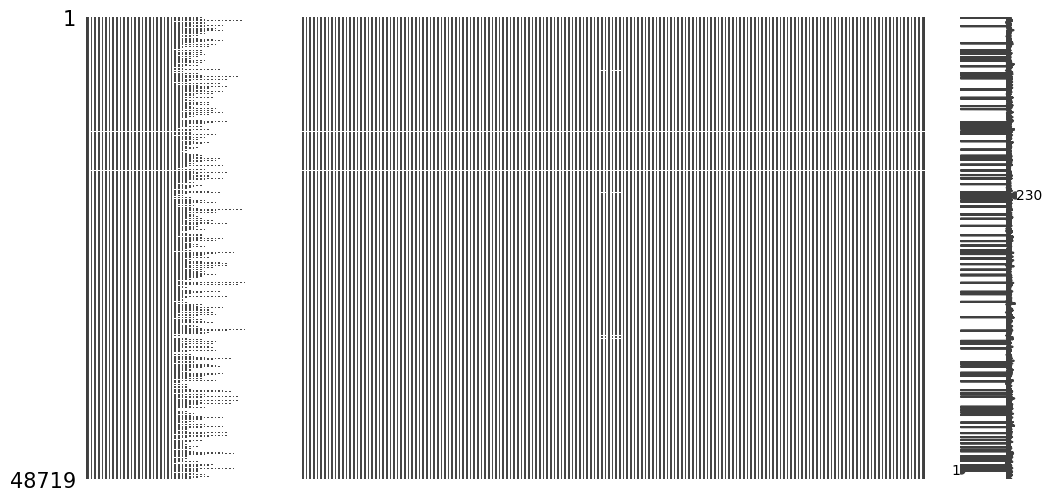

In [38]:
msno.matrix(final_df[nan_columns], figsize=(12,6), fontsize=12)
plt.show()

Од финалната табела се отстрануваат колоните со само една уникатна вредност, за да се задржат само информативните променливи.

In [39]:
final_df = final_df.loc[:, final_df.nunique(dropna=False) > 1]

Во финалната табела, специјализираните кодирани вредности за недостасувачки вредности објаснети во описот за податоци (-4, 88.8, 888, 888.8, 9, 99, 999, 9999) се заменуваат со пропуштени вредности (NaN) за сите релевантни колони.

In [40]:
patients_list = patients_df.columns.to_list()

In [41]:
values_to_replace = [-4, 88.8, 888, 888.8, 9, 99, 999, 9999]

existing_columns = [col for col in patients_list if col in final_df.columns]

final_df[existing_columns] = final_df[existing_columns].replace(values_to_replace, np.nan)

Се прикажува бројот на појавувања за секоја колона со null вредности, вклучувајќи ги NaN и другите вредности, за подобро разбирање на распределбата на податоците.

In [42]:
final_df.isnull().sum()[final_df.isnull().sum() > 0]

,0
WMH,2
BIRTHYR,439
SEX,439
HISPANIC,696
HISPOR,522
...,...
CANCER,441
DIABET,604
CONGHRT,441
AFIBRILL,441


In [43]:
cols_with_nan = final_df.columns[final_df.isnull().any()]

for col in cols_with_nan:
    print(f"--- {col} ---")
    print(final_df[col].value_counts(dropna=False))
    print()

--- WMH ---
WMH
1.163     117
0.925      98
0.000      90
0.349      86
0.714      83
         ... 
4.067       2
4.459       2
0.890       2
20.909      1
0.483       1
Name: count, Length: 3639, dtype: int64

--- BIRTHYR ---
BIRTHYR
1947.0    2913
1948.0    2636
1945.0    2592
1946.0    2519
1951.0    2431
          ... 
1989.0       4
2001.0       3
1977.0       2
1993.0       2
1982.0       2
Name: count, Length: 66, dtype: int64

--- SEX ---
SEX
2.0    28745
1.0    19535
NaN      439
Name: count, dtype: int64

--- HISPANIC ---
HISPANIC
0.0    44051
1.0     3972
NaN      696
Name: count, dtype: int64

--- HISPOR ---
HISPOR
88.0    44308
1.0      1478
2.0       684
6.0       602
NaN       522
4.0       403
3.0       334
5.0       222
50.0      166
Name: count, dtype: int64

--- RACE ---
RACE
1.0     38709
2.0      7443
50.0      773
NaN       683
5.0       564
3.0       539
4.0         8
Name: count, dtype: int64

--- RACESEC ---
RACESEC
88.0    46375
NaN       825
3.0       763
1.0

Графиките и хистограмите за секоја колона со пропуштени вредности овозможуваат визуелна анализа на распределбата на податоците и помагаат да се утврди најсоодветниот начин за нивно пополнување.

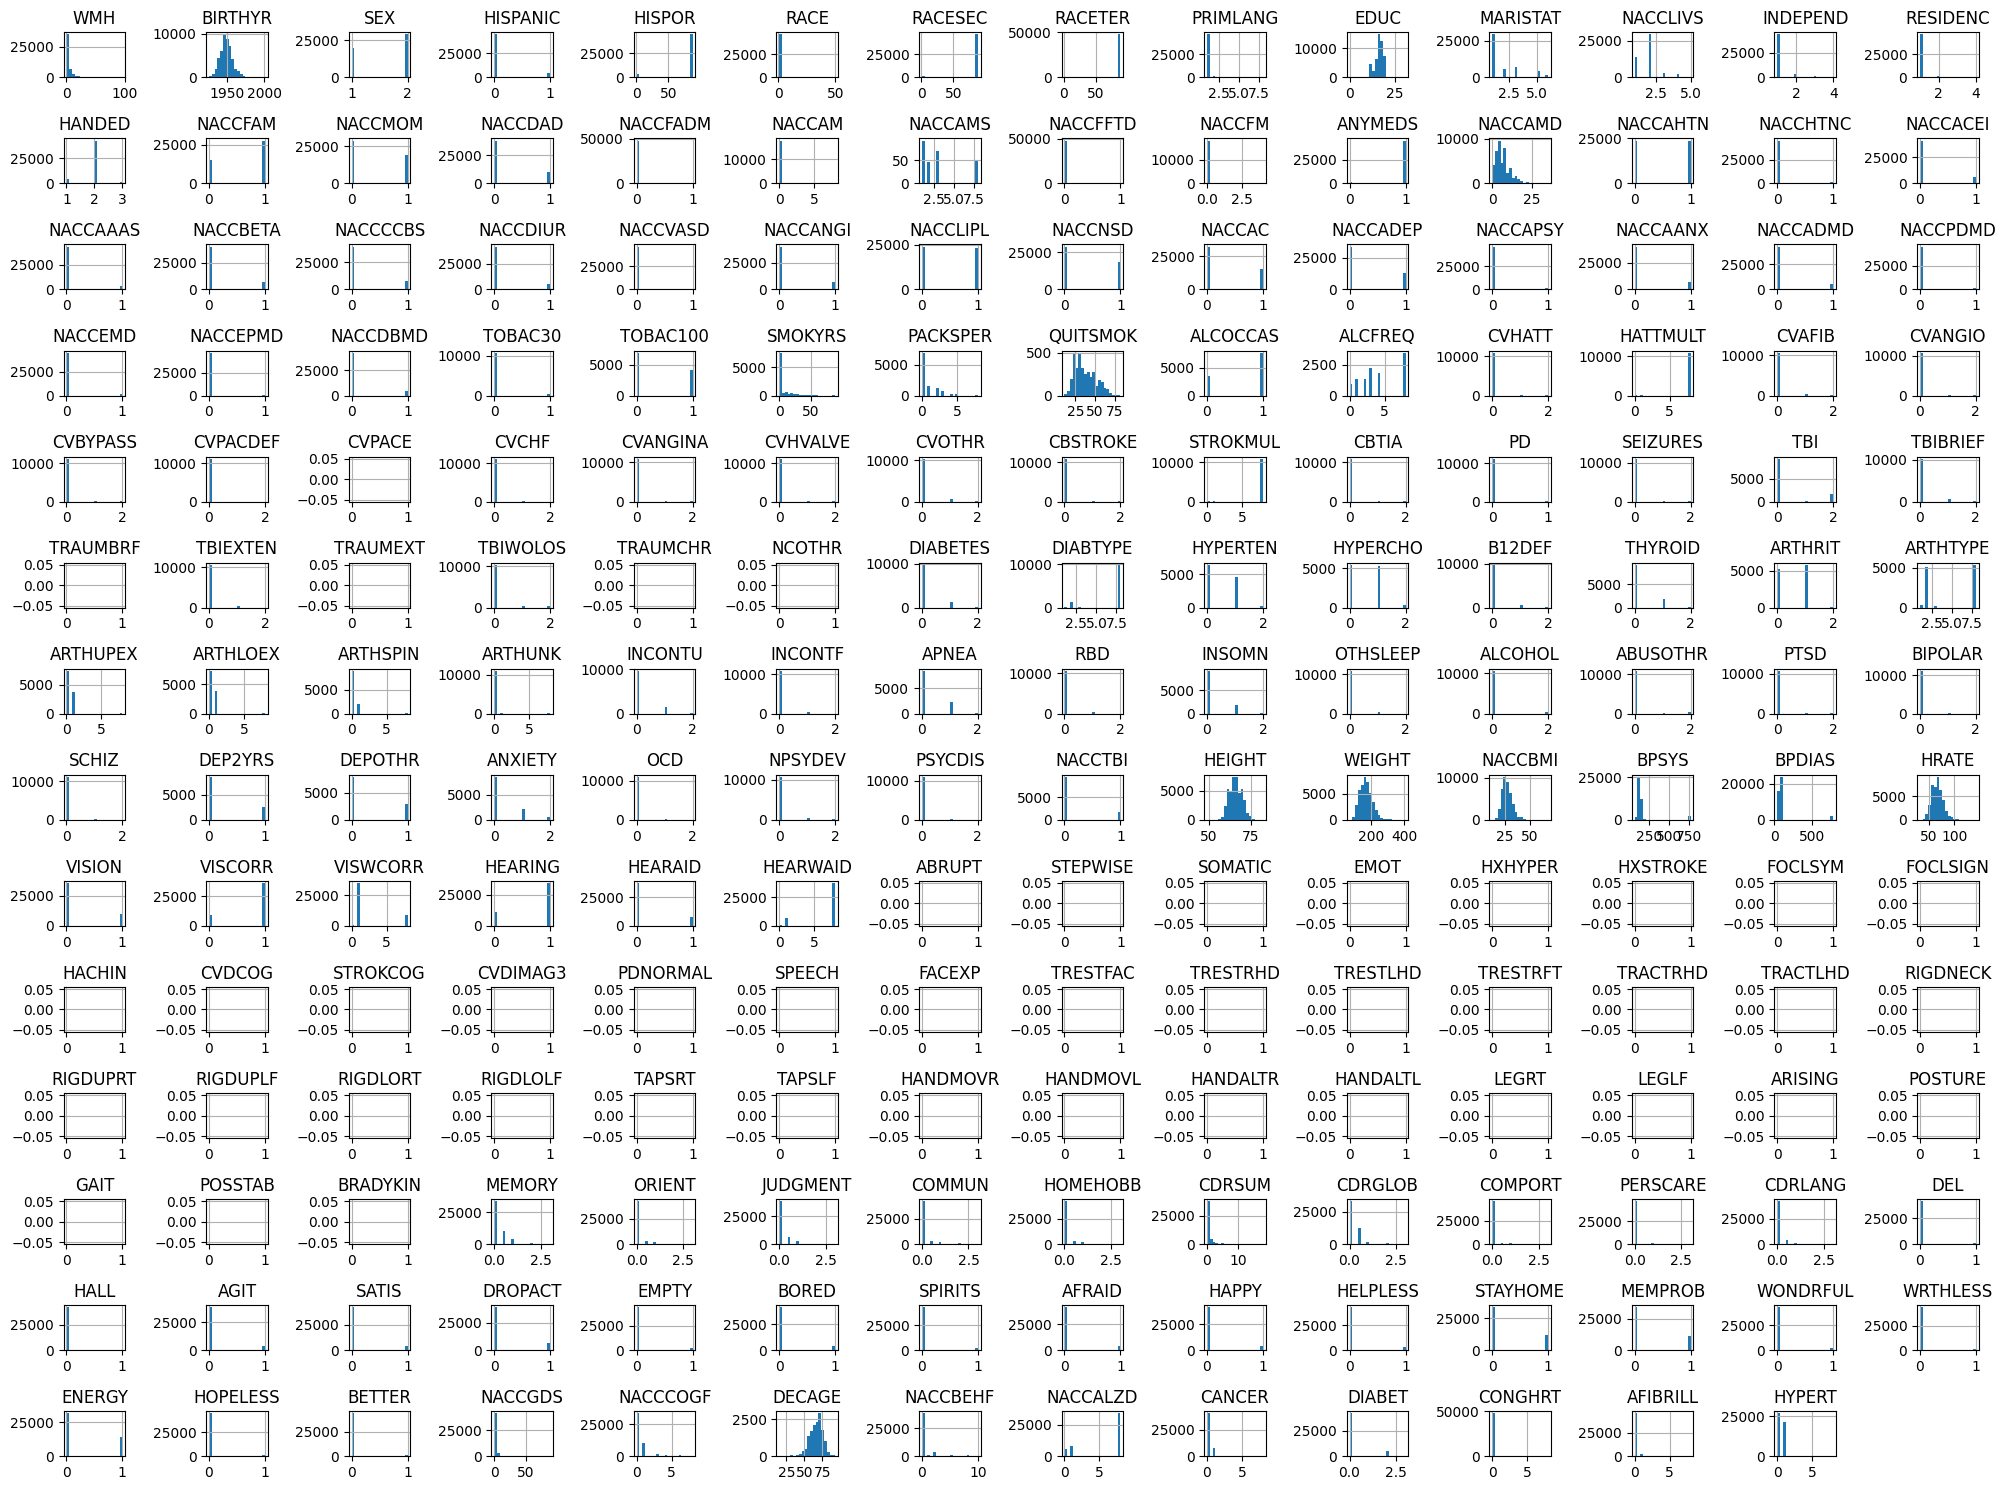

In [44]:
final_df[cols_with_nan].hist(bins=20, figsize=(20, 15))
plt.tight_layout()
plt.show()

Се создава список со имињата на сите колони во финалната табела кои содржат null вредности.

In [45]:
cols_with_nan.to_list()

['WMH',
 'BIRTHYR',
 'SEX',
 'HISPANIC',
 'HISPOR',
 'RACE',
 'RACESEC',
 'RACETER',
 'PRIMLANG',
 'EDUC',
 'MARISTAT',
 'NACCLIVS',
 'INDEPEND',
 'RESIDENC',
 'HANDED',
 'NACCFAM',
 'NACCMOM',
 'NACCDAD',
 'NACCFADM',
 'NACCAM',
 'NACCAMS',
 'NACCFFTD',
 'NACCFM',
 'ANYMEDS',
 'DRUG1',
 'DRUG2',
 'DRUG3',
 'DRUG4',
 'DRUG5',
 'DRUG6',
 'DRUG7',
 'DRUG8',
 'DRUG9',
 'DRUG10',
 'DRUG11',
 'DRUG12',
 'DRUG13',
 'DRUG14',
 'DRUG15',
 'DRUG16',
 'DRUG17',
 'DRUG18',
 'DRUG19',
 'DRUG20',
 'DRUG21',
 'DRUG22',
 'DRUG23',
 'DRUG24',
 'DRUG25',
 'DRUG26',
 'DRUG27',
 'DRUG28',
 'DRUG29',
 'DRUG30',
 'DRUG31',
 'DRUG32',
 'DRUG33',
 'DRUG34',
 'DRUG35',
 'NACCAMD',
 'NACCAHTN',
 'NACCHTNC',
 'NACCACEI',
 'NACCAAAS',
 'NACCBETA',
 'NACCCCBS',
 'NACCDIUR',
 'NACCVASD',
 'NACCANGI',
 'NACCLIPL',
 'NACCNSD',
 'NACCAC',
 'NACCADEP',
 'NACCAPSY',
 'NACCAANX',
 'NACCADMD',
 'NACCPDMD',
 'NACCEMD',
 'NACCEPMD',
 'NACCDBMD',
 'TOBAC30',
 'TOBAC100',
 'SMOKYRS',
 'PACKSPER',
 'QUITSMOK',
 'ALCOCCAS',
 '

Се пресметува корелацијата меѓу нумеричките променливи и се прикажува преку хитмап за визуелизација. Потоа таргет променливата NACCALZD се одделува, а од останатите бројчани колони се отстрануваат оние кои имаат висока меѓусебна корелација (>0.9), со цел да се намали мултиколинеарноста.

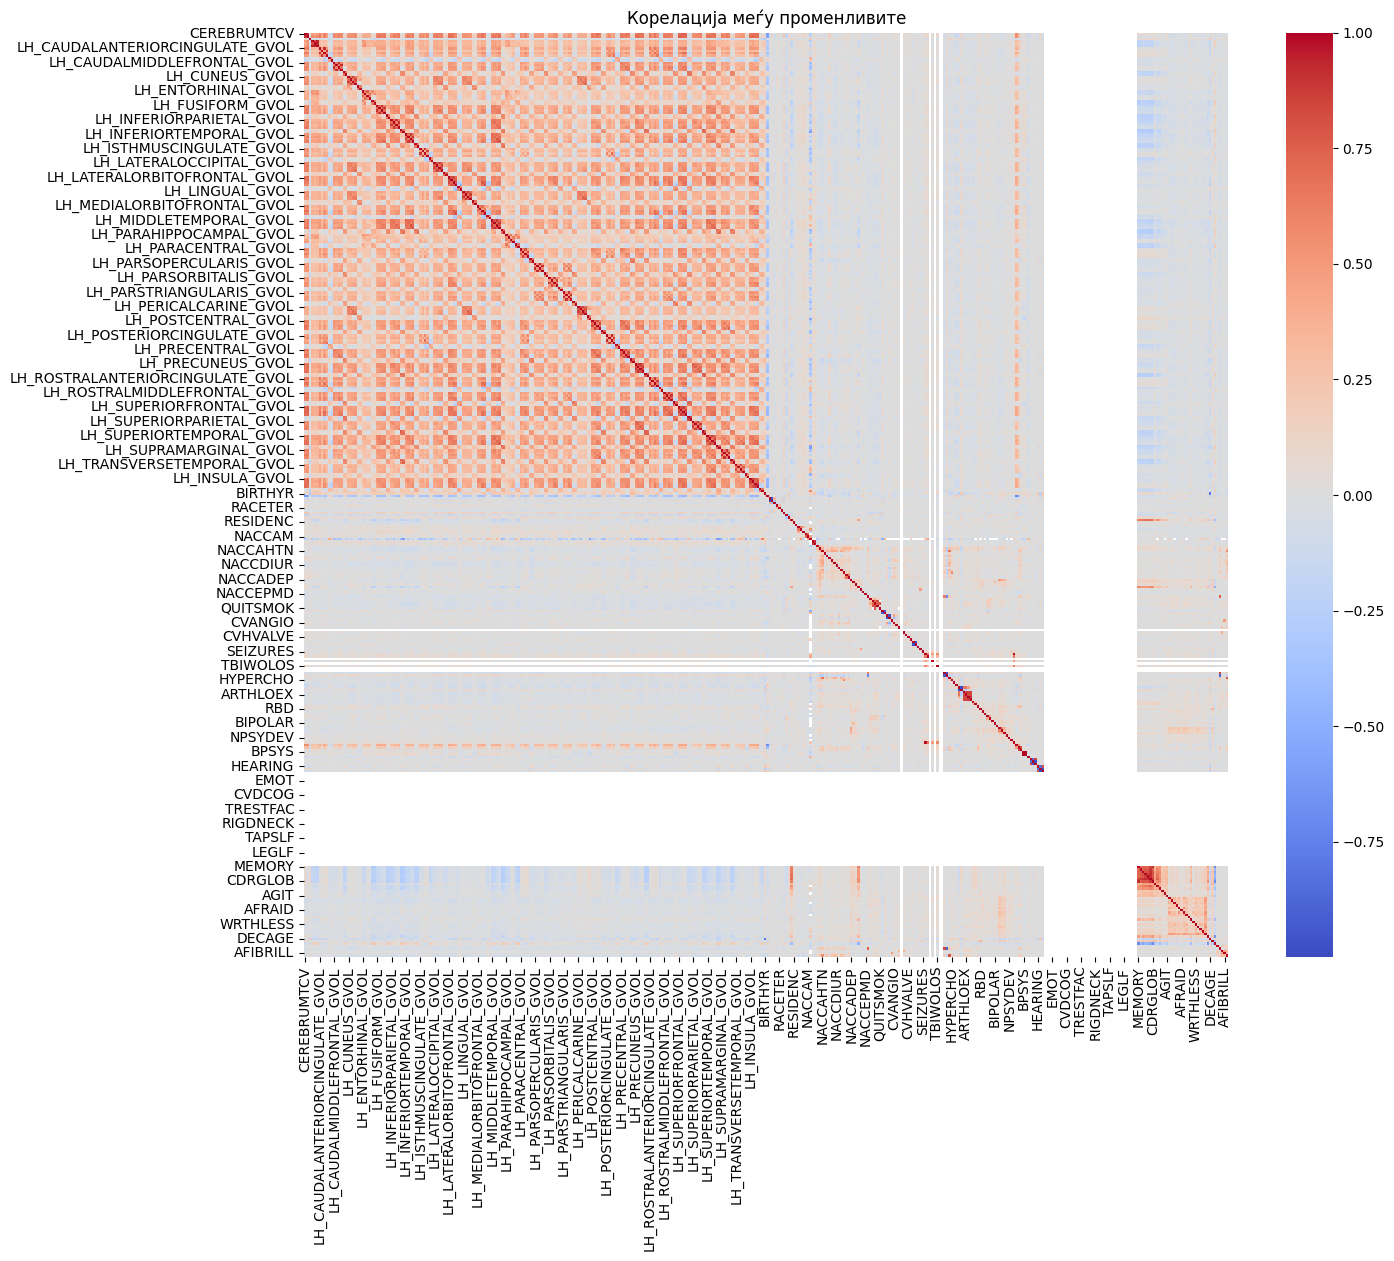

In [46]:
numeric_df = final_df.select_dtypes(include=['number'])
correlation_matrix = numeric_df.corr()
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0, square=True)
plt.title('Корелација меѓу променливите')
plt.show()


In [47]:
target = final_df['NACCALZD']
final_df.drop(columns='NACCALZD', inplace=True)

numeric_df = final_df.select_dtypes(include=[np.number])

corr_matrix = numeric_df.corr().abs()

upper = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

final_df_reduced = final_df.drop(columns=to_drop)

print("Беа отстранети колони:", to_drop)

Беа отстранети колони: ['GM', 'HIPPOCAMPUS', 'LH_CAUDALANTERIORCINGULATE_SAREA', 'LH_CAUDALMIDDLEFRONTAL_SAREA', 'RH_CAUDALMIDDLEFRONTAL_SAREA', 'LH_FUSIFORM_SAREA', 'RH_FUSIFORM_SAREA', 'LH_PARSOPERCULARIS_SAREA', 'RH_PARSOPERCULARIS_SAREA', 'LH_PARSTRIANGULARIS_SAREA', 'RH_PARSTRIANGULARIS_SAREA', 'LH_POSTERIORCINGULATE_SAREA', 'RH_PRECUNEUS_SAREA', 'LH_ROSTRALMIDDLEFRONTAL_SAREA', 'LH_SUPRAMARGINAL_SAREA', 'RH_SUPRAMARGINAL_SAREA', 'HISPOR', 'NACCFM', 'ALCFREQ', 'HATTMULT', 'STROKMUL', 'DIABTYPE', 'ARTHTYPE', 'NACCTBI', 'BPDIAS', 'VISWCORR', 'HEARWAID', 'CDRSUM', 'CDRGLOB']


In [48]:
target.isnull().sum()

np.int64(439)

Колоните со нормална распределба се пополнуваат со медијаната за да се заменат null вредности.

In [49]:
cols_to_fill = ["BIRTHYR", "HEIGHT", "WEIGHT", "NACCBMI", "HRATE", "QUITSMOK", "EDUC", "NACCAMD", "BPSYS", "DECAGE"]

for col in cols_to_fill:
    median_val = final_df_reduced[col].median()
    final_df_reduced[col].fillna(median_val, inplace=True)


/tmp/ipython-input-4253507386.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  final_df_reduced[col].fillna(median_val, inplace=True)


За сите останати бројчани колони со пропуштени вредности, кои не се пополнети со медијана, се користи мода за замена; ако мода не постои, вредностите се заменуваат со 0.

In [50]:
for col in final_df_reduced.select_dtypes(include=[np.number]).columns:
    if col not in cols_to_fill and final_df_reduced[col].isnull().sum() > 0:
        mode_series = final_df_reduced[col].mode()
        if not mode_series.empty:
            mode_val = mode_series[0]
            final_df_reduced[col].fillna(mode_val, inplace=True)
        else:
            final_df_reduced[col].fillna(0, inplace=True)

/tmp/ipython-input-2340126201.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  final_df_reduced[col].fillna(mode_val, inplace=True)
/tmp/ipython-input-2340126201.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', tr

Бројот на колони со преостанати пропуштени вредности е пресметан; сите непополнети колони се DRUG променливите, бидејќи NaN означува дека пациентот не прима одреден лек и треба да се енкодира како посебна вредност наместо да се пополнува.

In [51]:
num_cols_with_nan = final_df_reduced.isnull().sum()[final_df_reduced.isnull().sum() > 0].shape[0]
print("Број на колони со NaN:", num_cols_with_nan)

Број на колони со NaN: 35


## Модел

In [52]:
final_df_reduced['NACCALZD'] = target

/tmp/ipython-input-3428398294.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final_df_reduced['NACCALZD'] = target


In [53]:
final_df_reduced = final_df_reduced.dropna(subset=['NACCALZD'])

In [54]:
final_df_reduced['NACCID']

,NACCID
0,NACC000138
1,NACC000138
2,NACC000176
3,NACC000176
4,NACC000176
...,...
48714,NACC999617
48715,NACC999821
48716,NACC999821
48717,NACC999821


features → сите колони кои се feature-и, без NACCID, DATETIME и таргетот NACCALZD.

targets → остануваат само NACCID и NACCALZD, и со drop_duplicates() се задржуваат само уникатни комбинации на ID и таргет.

Ако еден пациент има повеќе мерења со ист таргет, ќе остане само еден ред за тој ID + таргет.

Ако еден пациент има различни таргети низ времето, ќе имаш повеќе редови за истиот NACCID, по еден за секоја различна вредност на NACCALZD.

In [55]:
features = final_df_reduced.drop(columns=["NACCID", "DATETIME", "NACCALZD"])
targets = final_df_reduced[["NACCID", "NACCALZD"]].drop_duplicates()

In [56]:
targets

,NACCID,NACCALZD
0,NACC000138,0.0
2,NACC000176,8.0
18,NACC000292,0.0
26,NACC000314,1.0
28,NACC000806,8.0
...,...,...
48631,NACC999225,8.0
48655,NACC999546,8.0
48703,NACC999573,8.0
48709,NACC999617,1.0


Овој код ги идентификува пациентите чија дијагноза се менувала низ времето. Од вкупно 4.819 мерења, 720 пациенти имаат повеќе од едно различно мерење, што укажува на промени или прогресија на дијагнозата кај тие пациенти.

In [57]:
changes = (
    final_df_reduced.groupby("NACCID")["NACCALZD"]
      .nunique()
      .reset_index()
)

changed_patients = changes[changes["NACCALZD"] > 1]

print("Број пациенти со различни резултати низ времето:", changed_patients.shape[0])

Број пациенти со различни резултати низ времето: 720


Овој код ги собира сите мерења на пациентите кај кои дијагнозата се менувала, ги става уникатните вредности на NACCALZD за секој пациент во листа и прикажува пример со првите пет пациенти за увид во нивните промени низ времето.

In [58]:
df_changed = final_df_reduced[final_df_reduced["NACCID"].isin(changed_patients["NACCID"])]

target_changes = (
    df_changed.groupby("NACCID")["NACCALZD"]
    .unique()  # list на уникатни вредности
    .reset_index()
)

sample_changes = target_changes.head(5)

print(sample_changes)

       NACCID         NACCALZD
0  NACC002424       [8.0, 1.0]
1  NACC002871       [8.0, 1.0]
2  NACC003658  [0.0, 1.0, 8.0]
3  NACC004873       [8.0, 0.0]
4  NACC005098       [8.0, 1.0]


In [59]:
final_df_reduced['NACCALZD'].isnull().sum()

np.int64(0)

In [60]:
final_df_reduced['NACCALZD']

,NACCALZD
0,0.0
1,0.0
2,8.0
3,8.0
4,8.0
...,...
48714,1.0
48715,8.0
48716,8.0
48717,8.0


Овој дел од кодот ја чисти табелата од дупликатите, така што за секој уникатен пар на пациентско ID (NACCID) и таргет (NACCALZD) се задржува само првиот ред. На овој начин се добива нов DataFrame (df_unique) кој содржи само уникатни записи, што го намалува бројот на редови и ја елиминира потенцијалната повторливост на податоците при тренирање на моделот.

In [61]:
id_col = "NACCID"
target_col = "NACCALZD"

df_unique = final_df_reduced.drop_duplicates(subset=[id_col, target_col], keep='first').reset_index(drop=True)

print("Број на редови после отстранување на дупликати:", df_unique.shape[0])
df_unique

Број на редови после отстранување на дупликати: 4687


,NACCID,DATETIME,CEREBRUMTCV,WMH,LEFT_HIPPO,RIGHT_HIPPO,LH_CAUDALANTERIORCINGULATE_GVOL,RH_CAUDALANTERIORCINGULATE_GVOL,RH_CAUDALANTERIORCINGULATE_SAREA,LH_CAUDALANTERIORCINGULATE_AVGTH,...,NACCGDS,NACCCOGF,DECAGE,NACCBEHF,CANCER,DIABET,CONGHRT,AFIBRILL,HYPERT,NACCALZD
0,NACC000138,2023-07-13 12:05:44,1098.37,0.390000,3.59400,3.58200,1987,1659,588,2.552,...,1.0,0.0,67.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,NACC000176,2023-01-31 11:12:51,1088.37,0.459185,2.91529,2.93531,2819,2254,710,2.512,...,0.0,0.0,67.0,0.0,0.0,0.0,0.0,0.0,1.0,8.0
2,NACC000292,2022-11-03 10:22:16,1205.06,1.356000,3.43500,3.38400,2602,1938,767,2.414,...,0.0,1.0,60.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,NACC000314,2024-02-20 14:30:16,1361.43,2.474000,2.96300,2.61400,2999,2331,1116,2.090,...,3.0,1.0,67.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0
4,NACC000806,2023-01-25 13:22:16,1271.12,0.123000,3.23700,3.24400,2787,1516,685,2.236,...,0.0,0.0,67.0,0.0,0.0,0.0,0.0,0.0,1.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4682,NACC999225,2024-04-16 11:46:33,1044.92,1.344000,2.95200,3.01300,2540,1990,664,2.315,...,0.0,0.0,67.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0
4683,NACC999546,2021-03-03 10:05:28,1266.93,0.886000,3.42500,3.48900,3260,1987,810,2.515,...,1.0,0.0,67.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0
4684,NACC999573,2022-09-09 15:10:48,1135.26,7.696000,3.01000,3.05100,2045,2038,699,2.457,...,1.0,0.0,67.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0
4685,NACC999617,2023-04-11 13:22:18,1074.84,1.711260,3.32775,3.45857,2174,2151,810,2.431,...,0.0,0.0,67.0,0.0,0.0,2.0,0.0,0.0,1.0,1.0


Кодот тренира LSTM модел за предвидување на таргет колоната (NACCALZD) од временски серии по пациенти. Податоците се обработуваат со One-Hot, стандардизација и PCA, а потоа се делат на train и test по пациенти. LSTM моделот учи од train делот, а перформансите се мерат на test делот. На крај со SHAP се одредуваат најважните PCA компоненти и оригинални feature-и кои најмногу влијаат на предвидувањето.

Функцијата evaluate_model го проверува моделот на дадените податоци, собира предвидени и вистински labels, и пресметува точност (accuracy), precision, recall, F1 score по класа, како и confusion matrix за да ја оцени перформансата на моделот.

Генерира две графики за визуелизација на перформансите на моделот по епоха.Лев график прикажува Loss за тренирачки и тест податоци. Десен график прикажува Accuracy за тренирачки и тест податоци

Целта е да се следи еволуцијата на загубата и точноста на моделот во текот на тренирањето

Epoch 1, Train Loss: 0.7202, Test Loss: 0.7604, Train Acc: 0.7263, Test Acc: 0.6950
Epoch 2, Train Loss: 0.6470, Test Loss: 0.7004, Train Acc: 0.7502, Test Acc: 0.7053
Epoch 3, Train Loss: 0.6033, Test Loss: 0.7094, Train Acc: 0.7589, Test Acc: 0.6963
Epoch 4, Train Loss: 0.5634, Test Loss: 0.6737, Train Acc: 0.7675, Test Acc: 0.7066
Epoch 5, Train Loss: 0.5149, Test Loss: 0.6364, Train Acc: 0.7898, Test Acc: 0.7207
Epoch 6, Train Loss: 0.5006, Test Loss: 0.6461, Train Acc: 0.7914, Test Acc: 0.7053
Epoch 7, Train Loss: 0.4875, Test Loss: 0.6424, Train Acc: 0.8091, Test Acc: 0.7336
Epoch 8, Train Loss: 0.4725, Test Loss: 0.6608, Train Acc: 0.8094, Test Acc: 0.7272
Epoch 9, Train Loss: 0.4406, Test Loss: 0.6708, Train Acc: 0.8245, Test Acc: 0.7310
Epoch 10, Train Loss: 0.4279, Test Loss: 0.6748, Train Acc: 0.8310, Test Acc: 0.7310

Final Test Loss: 0.6748
Final Test Accuracy: 0.7310
Test Precision per class: [0.49038462 0.5862069  0.84680851]
Test Recall per class: [0.37226277 0.66111111

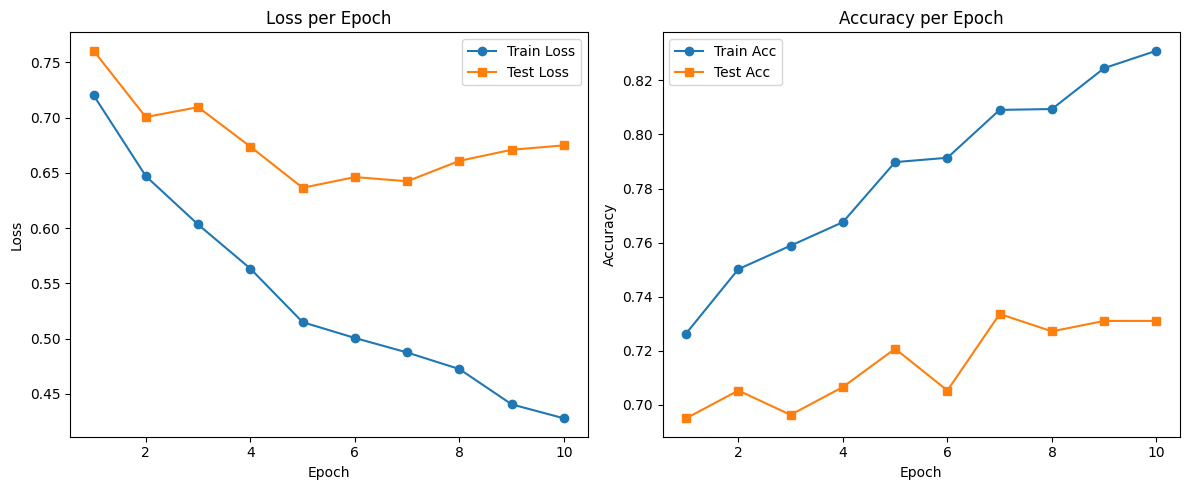

In [64]:
# --- 1. One-Hot за object колони ---
object_cols = [col for col in df_unique.columns
               if df_unique[col].dtype == 'object'
               and col not in [id_col, "DATETIME", target_col]]
if object_cols:
    df_unique = pd.get_dummies(df_unique, columns=object_cols)

# --- 2. Подготовка на feature-и ---
features_cols = [c for c in df_unique.columns if c not in [id_col, "DATETIME", target_col]]
features = df_unique[features_cols].fillna(0)

# --- 3. Стандардирање и PCA ---
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

pca = PCA(n_components=50)
features_pca = pca.fit_transform(features_scaled)

# Замена на оригинални feature-и со PCA
df_pca = df_unique[[id_col, "DATETIME", target_col]].copy()
for i in range(features_pca.shape[1]):
    df_pca[f"PCA_{i}"] = features_pca[:, i]

# --- 4. Dataset класа ---
class PatientDataset(Dataset):
    def __init__(self, df):
        self.groups = [g.sort_values("DATETIME") for _, g in df.groupby(id_col)]
    def __len__(self):
        return len(self.groups)
    def __getitem__(self, idx):
        group = self.groups[idx]
        X = group[[c for c in group.columns if "PCA_" in c]].values.astype(np.float32)
        y = int(group[target_col].iloc[-1])
        return torch.tensor(X), torch.tensor(y)

def collate_fn(batch):
    X_batch, y_batch = zip(*batch)
    X_batch = pad_sequence(X_batch, batch_first=True)
    y_batch = torch.stack(y_batch)
    return X_batch, y_batch

# --- 5. Поделба на train/test по пациенти ---
patient_ids = df_pca[id_col].unique()
train_ids, test_ids = train_test_split(patient_ids, test_size=0.2, random_state=42)

df_train = df_pca[df_pca[id_col].isin(train_ids)].copy()
df_test = df_pca[df_pca[id_col].isin(test_ids)].copy()

train_dataset = PatientDataset(df_train)
test_dataset = PatientDataset(df_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

# --- 6. LSTM модел ---
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

input_size = features_pca.shape[1]
hidden_size = 64
num_layers = 2
num_classes = int(df_pca[target_col].max() + 1)

model = LSTMClassifier(input_size, hidden_size, num_layers, num_classes)

# --- 7. Функција за евалуација со loss ---
def evaluate_model(model, dataloader, device, criterion):
    model.eval()
    all_preds = []
    all_labels = []
    total_loss = 0

    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            total_loss += loss.item()

            _, preds = torch.max(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    acc = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average=None, zero_division=0)
    cm = confusion_matrix(all_labels, all_preds)
    return avg_loss, acc, precision, recall, f1, cm

# --- 8. Тренинг со графици ---
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        out = model(X_batch)
        loss = criterion(out, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_train_loss = epoch_loss / len(train_loader)
    train_loss, train_acc, _, _, _, _ = evaluate_model(model, train_loader, device, criterion)
    test_loss, test_acc, _, _, _, _ = evaluate_model(model, test_loader, device, criterion)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")

# --- 9. Финална евалуација ---
test_loss, test_acc, test_precision, test_recall, test_f1, test_cm = evaluate_model(model, test_loader, device, criterion)

print(f"\nFinal Test Loss: {test_loss:.4f}")
print(f"Final Test Accuracy: {test_acc:.4f}")
print(f"Test Precision per class: {test_precision}")
print(f"Test Recall per class: {test_recall}")
print(f"Test F1 per class: {test_f1}")
print(f"Test Confusion Matrix:\n{test_cm}")

# --- 10. Графици ---
plt.figure(figsize=(12,5))

# Loss граф
plt.subplot(1,2,1)
plt.plot(range(1, len(train_losses)+1), train_losses, marker='o', label="Train Loss")
plt.plot(range(1, len(test_losses)+1), test_losses, marker='s', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()

# Accuracy граф
plt.subplot(1,2,2)
plt.plot(range(1, len(train_accuracies)+1), train_accuracies, marker='o', label="Train Acc")
plt.plot(range(1, len(test_accuracies)+1), test_accuracies, marker='s', label="Test Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per Epoch")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# --- 1. One-Hot за object колони ---
object_cols = [col for col in df_unique.columns
               if df_unique[col].dtype == 'object'
               and col not in [id_col, "DATETIME", target_col]]
if object_cols:
    df_unique = pd.get_dummies(df_unique, columns=object_cols)

# --- 2. Подготовка на feature-и ---
features_cols = [c for c in df_unique.columns if c not in [id_col, "DATETIME", target_col]]
features = df_unique[features_cols].fillna(0)

# --- 3. Стандардирање и PCA ---
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
pca = PCA(n_components=50)
features_pca = pca.fit_transform(features_scaled)

# Замена на оригинални feature-и со PCA
df_pca = df_unique[[id_col, "DATETIME", target_col]].copy()
for i in range(features_pca.shape[1]):
    df_pca[f"PCA_{i}"] = features_pca[:, i]

# --- 4. Dataset класа ---
class PatientDataset(Dataset):
    def __init__(self, df):
        self.groups = [g.sort_values("DATETIME") for _, g in df.groupby(id_col)]
    def __len__(self):
        return len(self.groups)
    def __getitem__(self, idx):
        group = self.groups[idx]
        X = group[[c for c in group.columns if "PCA_" in c]].values.astype(np.float32)
        y = int(group[target_col].iloc[-1])
        return torch.tensor(X), torch.tensor(y)

def collate_fn(batch):
    X_batch, y_batch = zip(*batch)
    X_batch = pad_sequence(X_batch, batch_first=True)
    y_batch = torch.stack(y_batch)
    return X_batch, y_batch

# --- 5. Поделба на train/test по пациенти ---
patient_ids = df_pca[id_col].unique()
train_ids, test_ids = train_test_split(patient_ids, test_size=0.2, random_state=42)
df_train = df_pca[df_pca[id_col].isin(train_ids)].copy()
df_test = df_pca[df_pca[id_col].isin(test_ids)].copy()

train_dataset = PatientDataset(df_train)
test_dataset = PatientDataset(df_test)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

# --- 6. LSTM модел ---
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

input_size = features_pca.shape[1]
hidden_size = 64
num_layers = 2
num_classes = int(df_pca[target_col].max() + 1)
model = LSTMClassifier(input_size, hidden_size, num_layers, num_classes)

# --- 7. Тренинг ---
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

for epoch in range(10):
    model.train()
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        out = model(X_batch)
        loss = criterion(out, y_batch)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

# --- 8. Подготовка на test sample со target=1 ---
df_test_target1 = df_test[df_test[target_col] == 1]
test_dataset_target1 = PatientDataset(df_test_target1)
test_loader_target1 = DataLoader(test_dataset_target1, batch_size=16, shuffle=False, collate_fn=collate_fn)

seq_len_fixed = 50
X_test_list = []
for X_batch, y_batch in test_loader_target1:
    for i in range(X_batch.size(0)):
        x = X_batch[i].cpu().numpy()
        if x.shape[0] < seq_len_fixed:
            pad_width = seq_len_fixed - x.shape[0]
            x_pad = np.pad(x, ((pad_width,0),(0,0)), mode='constant')
        else:
            x_pad = x[-seq_len_fixed:]
        X_test_list.append(x_pad.flatten())
X_test_flat_target1 = np.array(X_test_list, dtype=np.float32)

# --- 9. Подготовка на background sample ---
X_background_list = []
for X_batch, y_batch in train_loader:
    for i in range(X_batch.size(0)):
        x = X_batch[i].cpu().numpy()
        if x.shape[0] < seq_len_fixed:
            pad_width = seq_len_fixed - x.shape[0]
            x_pad = np.pad(x, ((pad_width,0),(0,0)), mode='constant')
        else:
            x_pad = x[-seq_len_fixed:]
        X_background_list.append(x_pad.flatten())
    if len(X_background_list) >= 20:
        break
X_background_flat = np.array(X_background_list, dtype=np.float32)

# --- 10. KernelExplainer ---
def model_predict_flat_target1(X_flat):
    batch_size = X_flat.shape[0]
    X_tensor = torch.tensor(X_flat.reshape(batch_size, seq_len_fixed, input_size), dtype=torch.float32).to(device)
    with torch.no_grad():
        out = model(X_tensor)
        probs = torch.softmax(out, dim=1)
    return probs[:,1].cpu().numpy().reshape(-1,1)  # probability for target=1

explainer = shap.KernelExplainer(model_predict_flat_target1, X_background_flat)
shap_values_target1 = explainer.shap_values(X_test_flat_target1)

# --- 11. Average SHAP по PCA ---
num_samples = X_test_flat_target1.shape[0]
shap_vals_reshaped = np.array(shap_values_target1).reshape(num_samples, seq_len_fixed, input_size)
mean_shap_per_pca = np.mean(np.abs(shap_vals_reshaped), axis=(0,1))

most_important_pca_idx = np.argmax(mean_shap_per_pca)
print("Most important PCA component for target=1:", most_important_pca_idx)

# --- 12. Map PCA назад на оригинални feature-и ---
pca_loadings = pca.components_[most_important_pca_idx]
important_features_idx = np.argsort(np.abs(pca_loadings))[::-1]
important_features = [features_cols[i] for i in important_features_idx]
print("Top original features contributing to target=1:", important_features[:10])


Epoch 1, Loss: 1.4175
Epoch 2, Loss: 0.4915
Epoch 3, Loss: 0.4475
Epoch 4, Loss: 0.6571
Epoch 5, Loss: 0.1396
Epoch 6, Loss: 0.5295
Epoch 7, Loss: 0.3461
Epoch 8, Loss: 1.4520
Epoch 9, Loss: 0.5432
Epoch 10, Loss: 0.0726


  0%|          | 0/225 [00:00<?, ?it/s]

Most important PCA component for target=1: 0
Top original features contributing to target=1: ['CEREBRUMTCV', 'LH_LATERALORBITOFRONTAL_GVOL', 'RH_SUPERIORFRONTAL_GVOL', 'LH_SUPERIORFRONTAL_GVOL', 'RH_SUPERIORTEMPORAL_GVOL', 'RH_LATERALORBITOFRONTAL_GVOL', 'LH_SUPERIORTEMPORAL_GVOL', 'RH_PRECUNEUS_GVOL', 'RH_MIDDLETEMPORAL_GVOL', 'RH_SUPERIORFRONTAL_SAREA']


NameError: name 'v' is not defined

## Заклучок

Резултатите од LSTM моделот за предвидување на развој на Алцхајмерова болест покажуваат постепено подобрување на перформансите низ епохите. За секоја епоха се регистрирани Train Loss и Test Loss, како и Train Accuracy и Test Accuracy.

F1-скорите по класа покажуваат дека моделот најдобро ги идентификува пациентите од класа 2 со F1-скор од 0.856, додека класа 0 има помала точност и F1-скор од 0.423. Confusion matrix-от ја потврдува оваа тенденција: моделот успешно ги препознава пациентите без когнитивно оштетување и дел од пациентите со умерен когнитивен пад, додека постојат предизвици кај точната класификација на класа 0 и класа 1.

Овие резултати ја потврдуваат способноста на LSTM моделот да ги моделира временските серии на податоците за пациентите и да предвиди ризик од развој на Алцхајмер. Комбинацијата од PCA-преработени feature-и од клинички и MRI податоци овозможува моделот да извлече значајни патерни и да го поддржи раното идентификување на пациенти со висок ризик, што е критично за навремена интервенција и персонализирани терапевтски стратегии.

Со други зборови, LSTM моделот претставува ефикасен алат за предвидување на прогресијата на Алцхајмер во контекст на времески податоци од NACC базата.

Најдобрата епоха е околу 5-6, каде test loss е најниско, а test accuracy е најдобра. По тоа, продолжува тренингот и моделот се подобрува само на тренинг сетот, но не и на тест сетот.

Резултатите од анализата со PCA и SHAP покажуваат дека за класа 1 најважна е првата главна компонента (PCA компонентата 0). Оваа компонента претставува комбинација од повеќе оригинални карактеристики, но најголемо влијание врз неа имаат варијаблите: CEREBRUMTCV, LH_LATERALORBITOFRONTAL_GVOL, RH_SUPERIORFRONTAL_GVOL, LH_SUPERIORFRONTAL_GVOL, RH_SUPERIORTEMPORAL_GVOL, RH_LATERALORBITOFRONTAL_GVOL, LH_SUPERIORTEMPORAL_GVOL, RH_PRECUNEUS_GVOL, RH_MIDDLETEMPORAL_GVOL и RH_SUPERIORFRONTAL_SAREA.

Ова значи дека овие специфични мозочни региони и нивните волуметриски карактеристики имаат најсилно влијание врз одлуките на моделот при предвидување на класата 1, и тие можат да се сметаат за најрелевантни биомаркери во овој контекст.

## Извори

*The NACC database is funded by NIA/NIH Grant U24 AG072122. NACC data are contributed by the NIA-funded ADRCs: P30 AG062429 (PI James Brewer, MD, PhD), P30 AG066468 (PI Oscar Lopez, MD), P30 AG062421 (PI Bradley Hyman, MD, PhD), P30 AG066509 (PI Thomas Grabowski, MD), P30 AG066514 (PI Mary Sano, PhD), P30 AG066530 (PI Helena Chui, MD), P30 AG066507 (PI Marilyn Albert, PhD), P30 AG066444 (PI David Holtzman, MD), P30 AG066518 (PI Lisa Silbert, MD, MCR), P30 AG066512 (PI Thomas Wisniewski, MD), P30 AG066462 (PI Scott Small, MD), P30 AG072979 (PI David Wolk, MD), P30 AG072972 (PI Charles DeCarli, MD), P30 AG072976 (PI Andrew Saykin, PsyD), P30 AG072975 (PI Julie A. Schneider, MD, MS), P30 AG072978 (PI Ann McKee, MD), P30 AG072977 (PI Robert Vassar, PhD), P30 AG066519 (PI Frank LaFerla, PhD), P30 AG062677 (PI Ronald Petersen, MD, PhD), P30 AG079280 (PI Jessica Langbaum, PhD), P30 AG062422 (PI Gil Rabinovici, MD), P30 AG066511 (PI Allan Levey, MD, PhD), P30 AG072946 (PI Linda Van Eldik, PhD), P30 AG062715 (PI Sanjay Asthana, MD, FRCP), P30 AG072973 (PI Russell Swerdlow, MD), P30 AG066506 (PI Glenn Smith, PhD, ABPP), P30 AG066508 (PI Stephen Strittmatter, MD, PhD), P30 AG066515 (PI Victor Henderson, MD, MS), P30 AG072947 (PI Suzanne Craft, PhD), P30 AG072931 (PI Henry Paulson, MD, PhD), P30 AG066546 (PI Sudha Seshadri, MD), P30 AG086401 (PI Erik Roberson, MD, PhD), P30 AG086404 (PI Gary Rosenberg, MD), P20 AG068082 (PI Angela Jefferson, PhD), P30 AG072958 (PI Heather Whitson, MD), P30 AG072959 (PI James Leverenz, MD).*

<br>

*Data analysis was performed by Lina Paneva and Marija Stojkovska.*

*FINKI, Skopje 2025*